## 初期設定

In [2]:
# APIの基本設定
API_TOKEN = "YOUR_API_TOKEN"  # 実際のAPIトークンに置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin"
HEADERS = {"X-hojinInfo-api-token": API_TOKEN}

# APIリクエストの間隔（秒）- レート制限対策
REQUEST_INTERVAL = 0.5

print("API設定が完了しました")
print(f"Base URL: {BASE_URL}")

API設定が完了しました
Base URL: https://info.gbiz.go.jp/hojin


## 初期実行

In [3]:
from pprint import pprint
import requests

def get_subsidy_data():
   """
   gBizINFO APIから補助金情報を取得する関数
   """
   endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
   
   params = {
       'from': '20200401',
       'to': '20210331',
       'page': '1'
   }
   
   try:
       response = requests.get(endpoint, headers=HEADERS, params=params)
       
       if response.status_code == 200:
           return response.json()
       else:
           print(f"エラー: HTTPステータスコード {response.status_code}")
           print(f"レスポンス: {response.text}")
           return None
   except Exception as e:
       print(f"例外が発生しました: {e}")
       return None

# メイン処理
if __name__ == "__main__":
   print("gBizINFO APIから2020年度の補助金情報を取得しています...")
   data = get_subsidy_data()
   
   if data and "hojin-infos" in data:
      print(f"総件数: {data.get('totalCount', '不明')}")
      print(f"総ページ数: {data.get('totalPage', '不明')}")
       
       # 最初の5件のみ表示
      print("\n最初の1件の補助金データ:")
      pprint(data["hojin-infos"][0])
   else:
      print("データが取得できませんでした")

gBizINFO APIから2020年度の補助金情報を取得しています...
総件数: 91892
総ページ数: 919

最初の1件の補助金データ:
{'corporate_number': '1000020470007',
 'kana': 'おきなわけん',
 'location': '沖縄県那覇市泉崎１丁目２－２',
 'name': '沖縄県',
 'name_en': 'Okinawa Prefectural Government',
 'postal_code': '9000021',
 'status': '-',
 'subsidy': [{'amount': '6397000',
              'date_of_approval': '2020-07-08',
              'government_departments': '防衛省',
              'joint_signatures': None,
              'note': None,
              'subsidy_resource': None,
              'target': None,
              'title': '美咲特別支援学校防音事業（実施設計）'},
             {'amount': '2578000',
              'date_of_approval': '2020-06-04',
              'government_departments': '防衛省',
              'joint_signatures': None,
              'note': None,
              'subsidy_resource': None,
              'target': None,
              'title': 'コザ高等学校防音事業（実施設計）'},
             {'amount': '68977000',
              'date_of_approval': '2020-03-18',
              'governm

## DB用意

#### sqlite3_magic 定義

In [4]:
from IPython.core.magic import register_cell_magic
import sqlite3
import pandas as pd

# グローバル変数としてコネクションを保持
_conn = None
_cursor = None

@register_cell_magic
def sql(line, cell):
    """
    SQLiteクエリを実行するセルマジック
    使用例:
    %%sql sqlite:///miyagi_data.db
    SELECT * FROM table WHERE condition
    または接続済みの場合:
    %%sql
    SELECT * FROM table WHERE condition
    """
    global _conn, _cursor
    
    # 接続情報が指定されているか確認
    if line and line.startswith('sqlite:///'):
        db_path = line.replace('sqlite:///', '')
        if _conn:
            _conn.close()
        _conn = sqlite3.connect(db_path)
        _cursor = _conn.cursor()
        return f"{db_path} に接続しました"
        
    # 接続確認
    if not _conn or not _cursor:
        return "エラー: 最初に '%%sql sqlite:///ファイル名.db' で接続してください"
        
    try:
        if cell.lower().strip().startswith(('select', 'with')):
            # Pandasを使用して結果を表形式で表示
            df = pd.read_sql_query(cell, _conn)
            return df
        else:
            _cursor.execute(cell)
            _conn.commit()
            return "クエリを実行しました"
    except Exception as e:
        return f"エラー: {e}"

#### sqlite3_magic 接続

In [17]:
%%sql sqlite:///gbiz.sqlite3
select name from sqlite_master where type='table'

'gbiz.sqlite3 に接続しました'

#### テーブル作成

法人テーブル

In [6]:
%%sql
CREATE TABLE IF NOT EXISTS companies (
    corporate_number TEXT PRIMARY KEY,
    name TEXT,
    kana TEXT,
    name_en TEXT,
    location TEXT,
    postal_code TEXT,
    status TEXT,
    fiscal_year INTEGER,
    update_date TEXT
);


'クエリを実行しました'

補助金テーブル

In [7]:
%%sql
CREATE TABLE IF NOT EXISTS subsidies (
    id INTEGER PRIMARY KEY,
    corporate_number TEXT,
    title TEXT,
    amount TEXT,
    date_of_approval TEXT,
    government_departments TEXT,
    subsidy_resource TEXT,
    target TEXT,
    note TEXT,
    fiscal_year INTEGER,
    FOREIGN KEY (corporate_number) REFERENCES companies(corporate_number)
);

'クエリを実行しました'

In [18]:
%%sql
select name from sqlite_master where type='table';


,name
0,companies
1,subsidies
2,sqlite_sequence
3,processed_pages


In [19]:
%%sql
select count(*) from subsidies

,count(*)
0,231007


## 関数実装

In [10]:
import sqlite3
import aiohttp
import asyncio
import time

def period(fiscal_year):
    """年度から期間（開始日・終了日）を返す"""
    from_date = f"{fiscal_year}0401"
    to_date = f"{fiscal_year+1}0331"
    return from_date, to_date

def setup_database(conn):
    """データベーススキーマ設定（fiscal_yearカラム追加）"""
    cursor = conn.cursor()
    
    # 企業テーブル
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS companies (
        corporate_number TEXT,
        name TEXT,
        kana TEXT,
        name_en TEXT,
        location TEXT,
        postal_code TEXT,
        status TEXT,
        update_date TEXT,
        fiscal_year INTEGER,
        PRIMARY KEY (corporate_number, fiscal_year)
    )
    ''')
    
    # 補助金テーブル
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS subsidies (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        corporate_number TEXT,
        title TEXT,
        amount TEXT,
        date_of_approval TEXT,
        government_departments TEXT,
        subsidy_resource TEXT,
        target TEXT,
        note TEXT,
        fiscal_year INTEGER,
        FOREIGN KEY (corporate_number, fiscal_year) REFERENCES companies(corporate_number, fiscal_year)
    )
    ''')
    
    # 処理済みページ記録テーブル
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS processed_pages (
        data_type TEXT,
        page_number INTEGER,
        fiscal_year INTEGER,
        PRIMARY KEY (data_type, page_number, fiscal_year)
    )
    ''')
    
    conn.commit()
    return conn

async def fetch_subsidy_data(session, from_date=None, to_date=None, page=1):
    """非同期APIリクエスト - 補助金情報取得"""
    endpoint = f"{BASE_URL}/v1/hojin/updateInfo/subsidy"
    params = {
        'from': from_date,
        'to': to_date,
        'page': str(page)
    }
    
    try:
        async with session.get(endpoint, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"エラー: HTTPステータスコード {response.status}")
                return None
    except Exception as e:
        print(f"リクエストエラー: {e}")
        return None

def save_data_to_db(conn, data, fiscal_year):
    """データベースにデータを保存"""
    if not data or "hojin-infos" not in data:
        return 0, 0
    
    cursor = conn.cursor()
    companies_count = 0
    subsidies_count = 0
    
    for company in data["hojin-infos"]:
        # 法人情報の保存
        cursor.execute('''
        INSERT OR REPLACE INTO companies 
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            company.get("corporate_number", ""),
            company.get("name", ""),
            company.get("kana", ""),
            company.get("name_en", ""),
            company.get("location", ""),
            company.get("postal_code", ""),
            company.get("status", ""),
            company.get("update_date", ""),
            fiscal_year
        ))
        companies_count += cursor.rowcount
        
        # 補助金情報の保存
        if "subsidy" in company and company["subsidy"]:
            for subsidy in company["subsidy"]:
                cursor.execute('''
                INSERT INTO subsidies 
                VALUES (NULL, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                ''', (
                    company.get("corporate_number", ""),
                    subsidy.get("title", ""),
                    subsidy.get("amount", ""),
                    subsidy.get("date_of_approval", ""),
                    subsidy.get("government_departments", ""),
                    subsidy.get("subsidy_resource", ""),
                    subsidy.get("target", ""),
                    subsidy.get("note", ""),
                    fiscal_year
                ))
                subsidies_count += 1
    
    conn.commit()
    return companies_count, subsidies_count

def is_page_processed(conn, page, fiscal_year):
    """ページが処理済みかチェック"""
    cursor = conn.cursor()
    cursor.execute(
        'SELECT 1 FROM processed_pages WHERE data_type = ? AND page_number = ? AND fiscal_year = ?', 
        ('subsidy', page, fiscal_year)
    )
    return cursor.fetchone() is not None

def mark_page_processed(conn, page, fiscal_year):
    """ページを処理済みとしてマーク"""
    cursor = conn.cursor()
    cursor.execute(
        'INSERT OR IGNORE INTO processed_pages VALUES (?, ?, ?)', 
        ('subsidy', page, fiscal_year)
    )
    conn.commit()

async def get_subsidy_data_prod(from_date=None, to_date=None, fiscal_year=2020, db_connect=None):
    """非同期実行で全国の補助金情報を取得"""
    if from_date is None or to_date is None:
        from_date, to_date = period(fiscal_year)
    
    conn = db_connect if db_connect is not None else sqlite3.connect('gbiz.sqlite3')
    setup_database(conn)
    
    async with aiohttp.ClientSession() as session:
        # 最初に1ページ目を取得して総ページ数を確認
        initial_data = await fetch_subsidy_data(session, from_date, to_date, 1)
        if not initial_data or "totalPage" not in initial_data:
            print("総ページ数の取得に失敗しました")
            return
        
        total_pages = int(initial_data["totalPage"])
        print(f"補助金情報総ページ数: {total_pages}、期間: {from_date}～{to_date}、年度: {fiscal_year}")
        
        # 1ページ目の処理
        if not is_page_processed(conn, 1, fiscal_year):
            companies, subsidies = save_data_to_db(conn, initial_data, fiscal_year)
            mark_page_processed(conn, 1, fiscal_year)
            print(f"ページ 1: {companies}社の情報と{subsidies}件の補助金情報を保存")
        else:
            print("ページ 1は処理済みです")
        
        # 残りのページを10ページずつバッチ処理
        total_companies = 0
        total_subsidies = 0
        processed_pages = 1
        start_time = time.time()
        
        for start_page in range(2, total_pages + 1, 10):
            batch_tasks = []
            batch_pages = []
            
            for page in range(start_page, min(start_page + 10, total_pages + 1)):
                if not is_page_processed(conn, page, fiscal_year):
                    batch_tasks.append(fetch_subsidy_data(session, from_date, to_date, page))
                    batch_pages.append(page)
                else:
                    print(f"ページ {page} は処理済みです")
            
            if batch_tasks:
                print(f"バッチ取得: {len(batch_tasks)} ページ")
                results = await asyncio.gather(*batch_tasks)
                
                for i, result in enumerate(results):
                    page = batch_pages[i]
                    if result:
                        companies, subsidies = save_data_to_db(conn, result, fiscal_year)
                        mark_page_processed(conn, page, fiscal_year)
                        total_companies += companies
                        total_subsidies += subsidies
                        processed_pages += 1
                        
                        # 進捗表示
                        elapsed_time = time.time() - start_time
                        avg_time_per_page = elapsed_time / processed_pages if processed_pages > 0 else 0
                        remaining_pages = total_pages - processed_pages
                        est_remaining_time = avg_time_per_page * remaining_pages
                        
                        print(f"ページ {page}/{total_pages}: {companies}社, {subsidies}件 " +
                              f"(進捗: {processed_pages/total_pages*100:.1f}%, 残り約{est_remaining_time/60:.1f}分)")
                
                await asyncio.sleep(1)  # APIレート制限対策
    
    # 最終結果の表示
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM companies WHERE fiscal_year = ?", (fiscal_year,))
    total_companies = cursor.fetchone()[0]
    cursor.execute("SELECT COUNT(*) FROM subsidies WHERE fiscal_year = ?", (fiscal_year,))
    total_subsidies = cursor.fetchone()[0]
    
    elapsed_time = time.time() - start_time
    print(f"\n処理完了 ({elapsed_time/60:.1f}分): {fiscal_year}年度データ")
    print(f"データベースには{total_companies}社の法人情報と{total_subsidies}件の補助金情報があります")


In [33]:

"""
Done:
2023,
"""

# メイン処理
if __name__ == "__main__":
    
    fiscal_year = 2020
    from_date, to_date = period(fiscal_year)
    print(f"{fiscal_year}年度({from_date}～{to_date})の補助金データを取得します...")
    
    connect = sqlite3.connect('gbiz.sqlite3')

    await get_subsidy_data_prod(from_date=from_date, to_date=to_date, fiscal_year=fiscal_year, db_connect=connect)
    
    

2023年度(20230401～20240331)の補助金データを取得します...
補助金情報総ページ数: 2312、期間: 20230401～20240331、年度: 2023
ページ 1は処理済みです
ページ 2 は処理済みです
ページ 3 は処理済みです
ページ 4 は処理済みです
ページ 5 は処理済みです
ページ 6 は処理済みです
ページ 7 は処理済みです
ページ 8 は処理済みです
ページ 9 は処理済みです
ページ 10 は処理済みです
ページ 11 は処理済みです
ページ 12 は処理済みです
ページ 13 は処理済みです
ページ 14 は処理済みです
ページ 15 は処理済みです
ページ 16 は処理済みです
ページ 17 は処理済みです
ページ 18 は処理済みです
ページ 19 は処理済みです
ページ 20 は処理済みです
ページ 21 は処理済みです
ページ 22 は処理済みです
ページ 23 は処理済みです
ページ 24 は処理済みです
ページ 25 は処理済みです
ページ 26 は処理済みです
ページ 27 は処理済みです
ページ 28 は処理済みです
ページ 29 は処理済みです
ページ 30 は処理済みです
ページ 31 は処理済みです
ページ 32 は処理済みです
ページ 33 は処理済みです
ページ 34 は処理済みです
ページ 35 は処理済みです
ページ 36 は処理済みです
ページ 37 は処理済みです
ページ 38 は処理済みです
ページ 39 は処理済みです
ページ 40 は処理済みです
ページ 41 は処理済みです
ページ 42 は処理済みです
ページ 43 は処理済みです
ページ 44 は処理済みです
ページ 45 は処理済みです
ページ 46 は処理済みです
ページ 47 は処理済みです
ページ 48 は処理済みです
ページ 49 は処理済みです
ページ 50 は処理済みです
ページ 51 は処理済みです
ページ 52 は処理済みです
ページ 53 は処理済みです
ページ 54 は処理済みです
ページ 55 は処理済みです
ページ 56 は処理済みです
ページ 57 は処理済みです
ページ 58 は処理済みです
ページ 59 は処理済みです
ページ 60 は処理済みです
ページ 61 は処理済みです
ページ 6

In [1]:
import sqlite3
conn = sqlite3.connect('gbiz.sqlite3')

In [2]:
import pandas as pd

subsidy_df = pd.read_sql_query("SELECT * FROM subsidies", conn)
company_df = pd.read_sql_query("SELECT * FROM companies", conn)


In [3]:
import humanize

subsidy_df["円"] = subsidy_df["amount"].apply(humanize.intword)

subsidy_df.columns = subsidy_df.columns.astype(str)  # カラム名を文字列として明示
company_df.columns = company_df.columns.astype(str)  # カラム名を文字列として明示


## データ分析

In [4]:
company_counts_df = subsidy_df.groupby('corporate_number').agg({
    'id': 'count',
    'amount': lambda x: pd.to_numeric(x.fillna(0), errors='coerce').sum(),
    'government_departments': lambda x: x.nunique()
}).rename(columns={'id': 'subsidy_count', 'amount': 'total_amount'}).sort_values('subsidy_count', ascending=False)


/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_42158/4172010492.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'amount': lambda x: pd.to_numeric(x.fillna(0), errors='coerce').sum(),


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def subsidy_trend_analysis(df, variable, window_size, polyorder, skip_initial=10, return_groups=True):
    # データを取得
    subsidy_counts = df[variable].values
    x = np.arange(len(subsidy_counts))
    
    # サブプロットを作成（2行1列）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 全データを元のグラフに表示
    ax1.plot(x, subsidy_counts, 'o-', color='skyblue', alpha=0.5, label='Original Data')
    
    # Savitzky-Golay フィルターで平滑化（全データ）
    smoothed = savgol_filter(subsidy_counts, window_size, polyorder)
    ax1.plot(x, smoothed, '-', color='blue', linewidth=2, label='Smoothed Curve')
    
    # 初期の急激な変化を除外した範囲を強調表示
    ax1.axvspan(skip_initial, len(x), alpha=0.2, color='green', label='Analysis Range')
    
    ax1.set_title('Distribution of Subsidy Count (Linear)', fontsize=16)
    ax1.set_xlabel('Company Index', fontsize=12)
    ax1.set_ylabel('Subsidy Count', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 一次微分グラフ（変化率）- 制限範囲のみ
    # 制限範囲のデータと微分を計算
    x_limited = x[skip_initial:]
    smoothed_limited = smoothed[skip_initial:]
    derivatives = np.gradient(smoothed_limited)
    
    ax2.plot(x_limited, derivatives, '-', color='red', linewidth=2)
    
    # 微分の閾値を設定して、重要な変化点を検出
    threshold = np.std(derivatives) * 0.5
    significant_changes = np.where(np.abs(derivatives) > threshold)[0]
    
    # 微分が大きく変化する点をマーク
    ax2.scatter(x_limited[significant_changes], derivatives[significant_changes], 
               color='darkred', s=50, label='Significant Change Points')
    
    # 上位のいくつかの変化点を特定してラベル付け
    top_changes = sorted(significant_changes, key=lambda i: abs(derivatives[i]), reverse=True)[:5]
    
    # 元のインデックスに変換
    original_indices = [i + skip_initial for i in top_changes]
    
    for i, idx in enumerate(top_changes):
        original_idx = original_indices[i]
        ax2.annotate(f'idx={original_idx}, val={subsidy_counts[original_idx]}', 
                    xy=(x_limited[idx], derivatives[idx]),
                    xytext=(x_limited[idx]+5, derivatives[idx]),
                    arrowprops=dict(arrowstyle='->'))
    
    ax2.set_title('Change Rate (First Derivative) - Excluding Initial Range', fontsize=16)
    ax2.set_xlabel('Company Index', fontsize=12)
    ax2.set_ylabel('Change Rate', fontsize=12)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # グラフレイアウトの調整
    plt.tight_layout()
    plt.show()
    
    # 重要な変化点のインデックスとその値を表示
    print("Important change points (excluding initial range):")
    for i, idx in enumerate(top_changes):
        original_idx = original_indices[i]
        print(f"Index: {original_idx}, Subsidy Count: {subsidy_counts[original_idx]}, Change Rate: {derivatives[idx]:.4f}")
    
    # グループ分割を行う場合
    if return_groups:
        # 最も重要な変化点を特定（絶対値が最も大きい微分点を選択）
        critical_idx = sorted(top_changes, key=lambda i: abs(derivatives[i]), reverse=True)[0]
        original_critical_idx = critical_idx + skip_initial
        threshold_value = subsidy_counts[original_critical_idx]
        
        print(f"\nCritical threshold value: {threshold_value}")
        
        # 高頻度グループと低頻度グループに分割
        high_frequency_group_df = df[df[variable] >= threshold_value].copy()
        low_frequency_group_df = df[df[variable] < threshold_value].copy()
        
        print(f"High frequency group size: {len(high_frequency_group_df)}")
        print(f"Low frequency group size: {len(low_frequency_group_df)}")
        
        return high_frequency_group_df, low_frequency_group_df, threshold_value
    
    return None

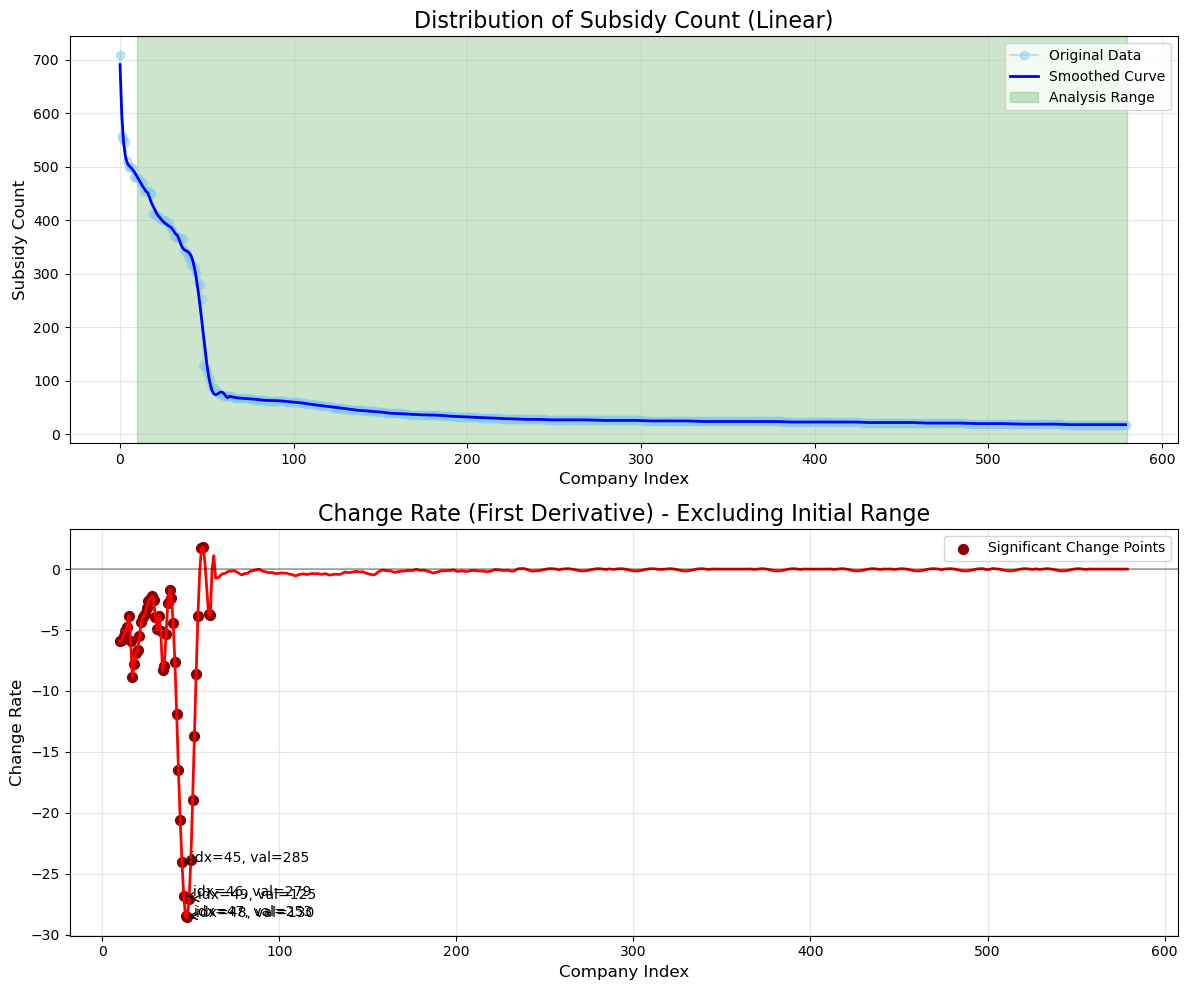

Important change points (excluding initial range):
Index: 48, Subsidy Count: 130, Change Rate: -28.5702
Index: 47, Subsidy Count: 253, Change Rate: -28.4847
Index: 49, Subsidy Count: 125, Change Rate: -27.1016
Index: 46, Subsidy Count: 279, Change Rate: -26.8472
Index: 45, Subsidy Count: 285, Change Rate: -24.0711

Critical threshold value: 130
High frequency group size: 49
Low frequency group size: 531


In [6]:
high_frequency_group_df, low_frequency_group_df, threshold_value = subsidy_trend_analysis(
  df=company_counts_df.head(580), 
  variable='subsidy_count',
  window_size=31, polyorder=7,
  skip_initial=10
)


In [7]:
low_frequency_group_df.shape[0]

531

In [8]:
df_outer = pd.merge(low_frequency_group_df, company_df, on='corporate_number', how='left')


In [9]:
df_outer.head()

,corporate_number,subsidy_count,total_amount,government_departments,name,kana,name_en,location,postal_code,status,update_date,fiscal_year
0,4020005004767,125,503251380744,1,独立行政法人鉄道建設・運輸施設整備支援機構,てつどうけんせつうんゆしせつせいびしえんきこう,,神奈川県横浜市中区本町６丁目５０番地１,2310005,-,2018-04-10T00:00:00+09:00,2023
1,6040005003798,117,3937081400,1,独立行政法人地域医療機能推進機構,ちいきいりょうきのうすいしんきこう,,東京都港区高輪３丁目２２番１２号,1080074,-,2018-04-23T00:00:00+09:00,2023
2,9000020281000,108,32066143739,7,神戸市,こうべし,Kobe City,兵庫県神戸市中央区加納町６丁目５－１,6500001,-,2018-04-12T00:00:00+09:00,2023
3,3000020231002,100,40352809084,7,名古屋市,なごやし,City of Nagoya,愛知県名古屋市中区三の丸３丁目１－１,4600001,-,2018-04-05T00:00:00+09:00,2023
4,3000020141003,89,50335758087,8,横浜市,よこはまし,City of Yokohama,神奈川県横浜市中区本町６丁目５０番地の１０,2310005,-,2020-06-11T00:00:00+09:00,2023


In [10]:
df_outer[["name","subsidy_count","total_amount"]].head(5)

,name,subsidy_count,total_amount
0,独立行政法人鉄道建設・運輸施設整備支援機構,125,503251380744
1,独立行政法人地域医療機能推進機構,117,3937081400
2,神戸市,108,32066143739
3,名古屋市,100,40352809084
4,横浜市,89,50335758087
